# Testing time marching in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Test time marching

First, we will solve an unconstrained system with an integrating factor

$\frac{\displaystyle du}{\displaystyle dt} = -\alpha u + \cos(\omega t)$

with $u(0) = u_0$. The exact solution is

$u(t) = u_0 e^{-\alpha t} + \frac{\displaystyle 1}{\displaystyle \alpha^2+\omega^2}\left(\alpha(\cos(\omega t)-e^{-\alpha t})+\omega \sin(\omega t)\right) $

In [3]:
α = 0.5
ω = 4
u₀ = 1.0
uex(t) = u₀*exp(-α*t) + (α*(cos(ω*t)-exp(-α*t))+ω*sin(ω*t))/(α^2+ω^2)

uex (generic function with 1 method)

Set up the integrating factor constructor

In [4]:
Whirl.plan_intfact(t::Float64,u::Vector{Float64}) = exp(-α*t)

In [5]:
Δt = 0.005
T = 0:Δt:10
u = [u₀]
r₁(u::Vector{Float64},t::Float64) = cos(ω*t)
ifrk = IFRK(u,Δt,plan_intfact,r₁,rk=TimeMarching.RK31)

Order-3 IF-RK integator with
   State of type Array{Float64,1}
   Time step size 0.005


In [6]:
u = [u₀]
uhist = Float64[]
for t in T
    push!(uhist,u[1])
    t,u = ifrk(t,u)
end

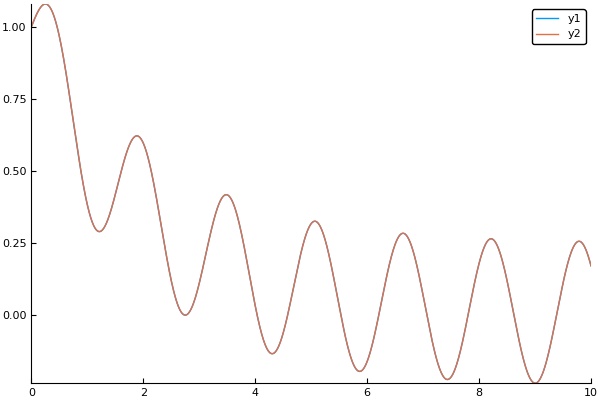

In [7]:
plot(T,uhist)
plot!(T,uex.(T))

In [8]:
norm(uhist-uex.(T))

0.01806544831164993

Now let's do a more interesting example: 2-d diffusion from a circle

In [9]:
nx = 129; ny = 129;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [10]:
n = 128;
θ = linspace(0,2π,n+1);
R = 0.5;
xb = 1.0 + R*cos.(θ[1:n])
yb = 1.0 + R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
f = ScalarData(X);

In [11]:
E = Regularize(X,dx;ddftype=Fields.Roma,issymmetric=true)
Hmat, Emat = RegularizationMatrix(E,f,w);

In [12]:
r₁(w::Nodes{T,NX,NY},t::Float64) where {T,NX,NY} = Nodes(T,w)
r₂(w::Nodes{T,NX,NY},t::Float64) where {T,NX,NY} = 1.0

r₂ (generic function with 1 method)

In [13]:
Δt = 1.0
ifherk = IFHERK(w,f,Δt,plan_intfact,(Hmat,Emat),(r₁,r₂),rk=TimeMarching.Euler)

Order-1 IF-HERK integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,129,129}
   Force of type Whirl.Fields.ScalarData{128}
   Time step size 1.0


In [14]:
@time ifherk.S[1].B₂A⁻¹(w)
@time ifherk.S[1].S*f;
@time ifherk.S[1].A⁻¹B₁ᵀ(f);

  0.013313 seconds (133 allocations: 168.576 KiB)
  0.008224 seconds (31 allocations: 320.047 KiB)
  0.010872 seconds (43 allocations: 289.609 KiB)


In [15]:
t = 0.0
w = Nodes(Dual,(nx,ny));

In [16]:
@time for i = 1:20
    t,w,f = ifherk(t,w);
end

  1.727471 seconds (6.29 k allocations: 67.030 MiB, 1.52% gc time)


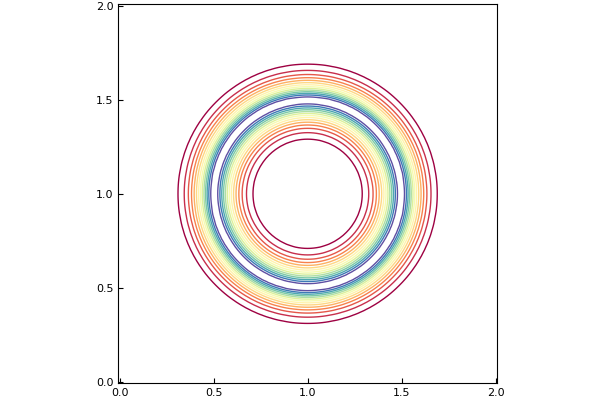

/Users/jeff/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


In [17]:
xg, yg = coordinates(w,dx=dx)
plot(xg,yg,w)

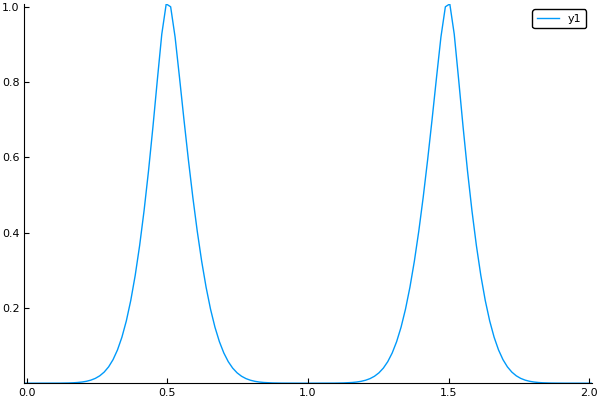

In [18]:
plot(xg,w[65,:])